In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
from util import *

In [0]:
# TODO: test loss and validation loss

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def train_it(dataset, model, Npast=1, Nfuture=1):
    #model = model
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Nepoch = 1000
    Nbatch = 100
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy)
        h = y_pred
        #for i in range(Nfuture-1):
            
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            losses[e//Nsave,0] = L.item()
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
    return losses

In [7]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    stash = {}
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model)
        stash[name] = {'model':model,
                       'loss':results}

Training  PureStencil
469 0.01521470956504345
939 0.00406392989680171
1409 0.0002677320153452456
1879 0.0018307684222236276
2349 0.000403088255552575
2819 0.00022238370729610324
3289 0.0003955545835196972
3759 0.00024500058498233557
4229 0.0003777329111471772
4699 0.0008053113706409931
Training  DeepStencil
469 0.015560504049062729
939 0.0008720715995877981
1409 0.00041461491491645575
1879 0.00031747555476613343
2349 0.0002078175311908126
2819 0.00020428105199243873
3289 0.00011526087473612279
3759 0.00027598533779382706
4229 0.0002196865389123559
4699 0.0001905523968162015
Training  FCMLP
469 1.545994746265933e-05
939 2.0683748971350724e-06
1409 1.2693188864432159e-06
1879 5.782363245998567e-07
2349 3.7865913782297866e-07
2819 4.33313914527389e-07
3289 4.1418766727474576e-07
3759 1.9540975415566209e-07
4229 3.14337285090005e-07
4699 2.0857390836681589e-07


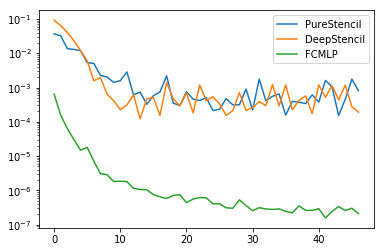

In [8]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
plt.legend()

PureStencil


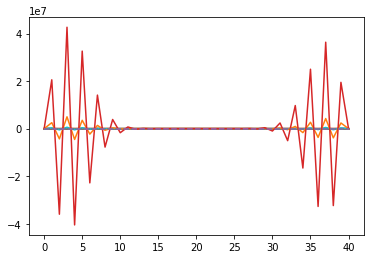

DeepStencil


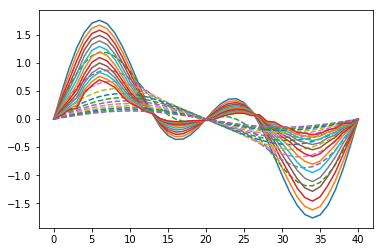

FCMLP


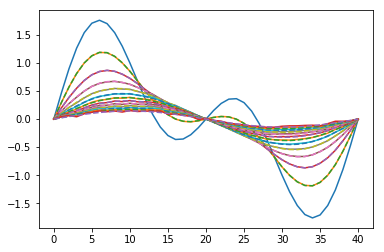

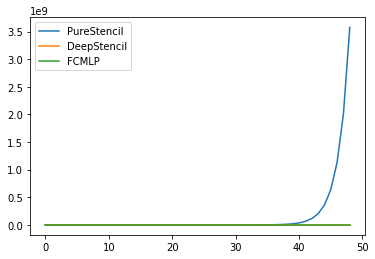

In [9]:
err = {}
for N,S in stash.items():
    print(N)
    err[N] = do_a_path(S['model'],dataset,5)
for N,e in err.items():
    plt.plot(e,label=N)
plt.legend()
plt.show()


In [10]:
list(stash["PureStencil"]['model'].parameters())

[Parameter containing:
 tensor([[[-0.1974,  0.3680, -0.1872]]], device='cuda:0', requires_grad=True)]

In [11]:
list(_)

[Parameter containing:
 tensor([[[-0.1974,  0.3680, -0.1872]]], device='cuda:0', requires_grad=True)]

In [0]:
import importlib
import util
importlib.reload(util)
from util import *

In [0]:
outfile = open(root+'/db','wb')
torch.save(stash,outfile)
outfile.close()

In [1]:
stash['PureStencil']['model'].parameters()

NameError: ignored